In [18]:
# http://jakevdp.github.io/blog/2014/03/11/frequentism-
# and-bayesianism-a-practical-intro/


# Generating simple photon count data
import numpy as np
from scipy import stats

from IPython.display import Image

In [5]:
np.random.seed(1)
F_true = 1000
N = 50 # number of measurements
F = stats.poisson(F_true).rvs(N)  # N measurements of flux
e = np.sqrt(F) # errors on Poisson counts estimated with sqrt rule. 
print("F = {0},\n\ne = {1}".format(F, e))

F = [ 992  962  968  991  993  970  992  961  983 1042  947  966  951 1079 1018
 1017  979  953 1050  980  971  999 1007 1008  953 1018  928 1015 1067 1049
  961  991 1058 1024 1044 1024  978  993 1015  956  995  992 1049  984 1044
 1050  966 1060  939 1020],

e = [ 31.4960315   31.01612484  31.11269837  31.48015248  31.51190251
  31.144823    31.4960315   31.          31.35283081  32.28002478
  30.77336511  31.08054054  30.83828789  32.84813541  31.90611227
  31.89043744  31.28897569  30.87069808  32.40370349  31.30495168
  31.1608729   31.60696126  31.73326331  31.74901573  30.87069808
  31.90611227  30.46309242  31.85906464  32.66496594  32.38826948  31.
  31.48015248  32.52691193  32.          32.31098884  32.          31.27299154
  31.51190251  31.85906464  30.91924967  31.54362059  31.4960315
  32.38826948  31.36877428  32.31098884  32.40370349  31.08054054
  32.55764119  30.64310689  31.93743885]


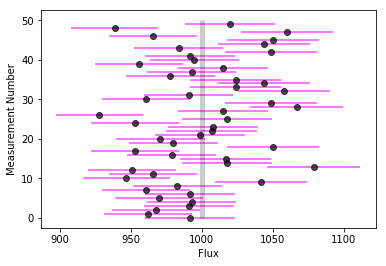

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
#ax.set_facecolor('white') # already the default
plt.gcf().set_facecolor('white') # axes bg color 
ax.errorbar(F, np.arange(N), xerr=e, fmt='ok', ecolor='magenta', alpha=0.7)
ax.vlines([F_true], 0, N, linewidth=5, alpha=0.2)
ax.set_xlabel("Flux")
ax.set_ylabel("Measurement Number")

In [ ]:
# GOAL QUESTION: Given our measurements and errors what is the best
# estimate of the true flux?

In [ ]:
# FREQUENTIST APPROACH TO PHOTON COUNTS


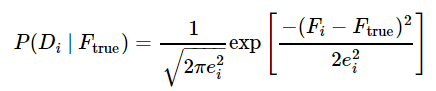

In [19]:
# Di = (Fi, ei) = single observation
# P(Di | F_true) = normal density, mean = F_true, stddev = ei
Image(filename="images/prob_d_given_F_true.png")

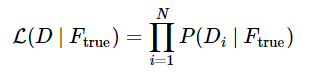

In [24]:
# Likelihood function: product of P(Di | F_true) for each data point, i.
# better to compute log likelihood since likelihood values are small.
# likelihood maximized => derivative set to zero => F_est = 1/ei^2
# error of F_est is stdev_est = 1/sqrt((sum wi))

Image(filename="images/likelihood.png")

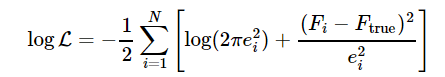

In [23]:
Image(filename="images/loglikelihood.png")

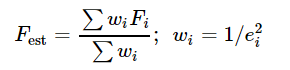

In [25]:
Image(filename="images/F_est.png")

In [7]:
# value of trueFlux such that likelihood is maximized
# results in wi = 1/ei^2
w = 1. / e**2
print(""" 
      F_true = {0}
      F_est = {1:.0f} +/- {2:.0f} (based on {3} measurements)
      """.format(F_true, 
                 sum(w * F) / sum(w),
                 sum(w)**-0.5,  # error estimate of 0.4%
                 N))
# w.sum()**(-0.5) # this is the stdeviation.

 
      F_true = 1000
      F_est = 998 +/- 4 (based on 50 measurements)
      


In [2]:
# Conclusion: for 50 measurements of the flux our estimate
# F_est is around 998 and has error (stdev) of 0.4%.

In [ ]:
## BAYESIAN APPROACH TO PHOTON COUNTS

# want to find: P(F_true | D) --- frequentism statistics says this has no
# meaning because probabilities have no meaning for model parameters.

# P(F_true | D) = P(F_true) * P(D | F_true) / P(D)

# P(F_true) = model prior, better to make this choice explicit and include
# some subjectivity rather than skirting the question. 
# P(D) = data probability, normalization term. 
# P(D | F_true) = likelihood
# P(F_true | D) = posterior, probability of model params given data.

# Goal: use emcee (MCMC sampling) to generate data points drawn from 
# posterior distribution and use those to determine the answer.

In [8]:
def logPrior(theta): # theta = H = hypothesis = F_true 
    return 1 # flat prior 

def logLikelihood(theta, F, e): # theta = Hypo
    return -0.5 * np.sum(np.log(2 * np.pi * e ** 2)
                         + (F - theta[0]) ** 2 / e ** 2)

def logPosterior(theta, F, e):
    # adding means multiplication on real number line. 
    return logPrior(theta) + logLikelihood(theta, F, e)

In [9]:
## generating some random starting guesses
ndim = 1 # num parameters in model 
nwalkers = 50 # number of MCMC walkers
nburn = 1000 # burn in period to let chains stabilize
nsteps = 2000 # number of MCMC steps to take


# start at random locations between 0 and 20
startingGuesses = 2000 * np.random.rand(nwalkers, ndim)

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior, args=[F, e])
sampler.run_mcmc(startingGuesses, nsteps)

sample = sampler.chain # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].ravel() # discard burn-in points

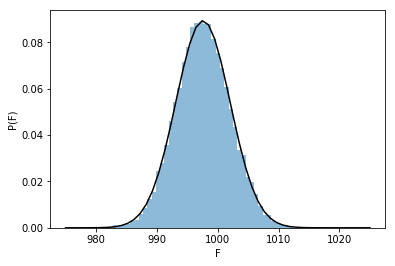

In [10]:
# plot histogram of the sample (sample contains 50000 points drawn from
# the posterior). 
plt.gcf().set_facecolor('white') # axes bg color 
plt.hist(sample, bins=50, histtype="stepfilled", alpha=0.5, normed=True)

# plot a best-fit Gaussian
F_fit = np.linspace(975, 1025)
pdf = stats.norm(np.mean(sample), np.std(sample)).pdf(F_fit)

plt.plot(F_fit, pdf, "-k")
plt.xlabel("F")
plt.ylabel("P(F)")

In [11]:
# The mean and standard deviation of this posterior data points sample
# are the corollary of frequentist max likelihood estimate above
print(""" 
      F_true = {0}
      F_est = {1:.0f} +/- {2:.0f} (based on {3} measurements)
      """.format(F_true,
                 np.mean(sample), # sum(w * F) / sum(w),
                 np.std(sample), #sum(w)**-0.5,
                 N))

 
      F_true = 1000
      F_est = 998 +/- 4 (based on 50 measurements)
      


In [ ]:
# CONCLUSION: bayesian approach yields same result as frequentist.

In [ ]:
# ADDING A DIMENSION: exploring the stochastic flux model
# Instead of assuming star flux is static, we now assume it has some
# stochastic variation (varies with time unpredictably)
# Model used: 2-parameter Gaussian: theta = [mu, sigma], where sigma =
# stdev of variability intrinsic to the object. 

In [12]:
np.random.seed(42)
N = 100
mu_true, sigma_true = 1000, 15 # stochastic flux model

F_true = stats.norm(mu_true, sigma_true).rvs(N) # (unknown) true flux
F = stats.poisson(F_true).rvs() # observed flux: true flux + poisson errors.
e = np.sqrt(F) # errors formula

print("F_true = {0},\n\nF = {1}, \n\ne = {2}".format(F_true, F, e))

F_true = [ 1007.4507123    997.92603548  1009.71532807  1022.84544785   996.48769938
   996.48794565  1023.68819223  1011.51152094   992.95788421  1008.13840065
   993.04873461   993.0140537   1003.62943407   971.30079633   974.12623251
   991.56568706   984.80753319  1004.71370999   986.37963887   978.81544448
  1021.98473153   996.61335549  1001.01292307   978.62877721   991.83425913
  1001.66383885   982.73509634  1005.63547028   990.99041965   995.62459375
   990.97440082  1027.78417277   999.79754163   984.13433607  1012.33817368
   981.68734525  1003.13295393   970.60494814   980.07720927  1002.95291854
  1011.0769987   1002.57052422   998.26527576   995.48344457   977.82217014
   989.20233687   993.09041844  1015.85683339  1005.15427434   973.55439767
  1004.86125954   994.22376579   989.84617     1009.17514433  1015.46499284
  1013.96920179   987.41173715   995.36181436  1004.96895147  1014.63317691
   992.81238643   997.21511535   983.40497539   982.05690064  1012.18788734
  1

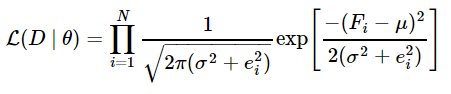

In [20]:
# The likelihood of this model is the mix of the intrinsic distribution
# with the error distribution... (see formula)

Image(filename="images/likelihood2.png")